In [22]:
import sys
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image, display
import seaborn as sns
import cmocean.cm as cmo
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy.mpl.geoaxes import GeoAxes

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from composite_funcs import flatten
from eofs import *
from plotter import draw_basemap

In [2]:
## load PRISM watershed precip dataset
path_to_data = '/expanse/nfs/cw3e/cwp140/'
fname = path_to_data + 'preprocessed/PRISM/PRISM_HUC8_CO_sp.nc'
PRISM = xr.open_dataset(fname)
HUC8_lst = PRISM.HUC8.values ## get list of HUC8 IDs

ds_lst = []
## load final trajectory dataset
for i, HUC8_ID in enumerate(HUC8_lst):
    fname = path_to_data + 'preprocessed/ERA5_trajectories/combined_extreme_AR/PRISM_HUC8_{0}.nc'.format(HUC8_ID)
    traj = xr.open_dataset(fname)
    ds_lst.append(traj)

## concat ds_lst along HUC8 index
ds = xr.concat(ds_lst, pd.Index(HUC8_lst, name="HUC8"))
ds

<xarray.Dataset>
Dimensions:             (index: 72, start_date: 1641, HUC8: 92)
Coordinates:
  * index               (index) int64 0 1 2 3 4 5 6 7 ... 65 66 67 68 69 70 71
  * start_date          (start_date) datetime64[ns] 2000-01-11 ... 2023-12-26
    time                (HUC8, start_date, index) datetime64[ns] NaT NaT ... NaT
    lon                 (HUC8, start_date, index) float64 nan nan ... nan nan
    lat                 (HUC8, start_date, index) float64 nan nan ... nan nan
  * HUC8                (HUC8) object '14080107' '14080105' ... '10250013'
Data variables: (12/18)
    level               (HUC8, start_date, index) float64 nan nan ... nan nan
    q                   (HUC8, start_date, index) float64 nan nan ... nan nan
    u                   (HUC8, start_date, index) float64 nan nan ... nan nan
    v                   (HUC8, start_date, index) float64 nan nan ... nan nan
    w                   (HUC8, start_date, index) float64 nan nan ... nan nan
    IVT                 (HUC8, start_date, index) float64 nan nan ... nan nan
    ...                  ...
    coastal_IVT         (HUC8, start_date) float64 nan nan nan ... nan nan nan
    ar_scale_strict     (HUC8, start_date) float64 nan nan nan ... nan nan nan
    ar_strict           (HUC8, start_date) float64 nan nan nan ... nan nan nan
    tARget_strict       (HUC8, start_date) float64 nan nan nan ... nan nan nan
    coastal_IVT_strict  (HUC8, start_date) float64 nan nan nan ... nan nan nan
    time_match          (HUC8, start_date) object nan nan nan ... nan nan nan

In [3]:
## create a list of unique dates 
## when a top-decile precip day was associated with an AR at the coast
t_lst = []
ar_varname = 'ar_scale'
## loop through HUC8s and start_dates
for i, HUC8 in enumerate(HUC8_lst):
    # subset to the current HUC8
    ## keep only trajectories associated with ARs
    tmp = ds.sel(HUC8=HUC8)
    tmp = tmp.where(tmp[ar_varname] > 0, drop=True)
    t_lst.append(tmp.start_date.values)

## make a copy of the df but keep only time/index
d = {'datetime': flatten(t_lst)}
times_df = pd.DataFrame(d)
times_df = times_df.drop_duplicates(subset=['datetime'])
times_df

,datetime
0,2003-02-26
1,2003-03-17
2,2003-09-10
3,2003-11-13
4,2004-04-04
...,...
2814,2018-06-25
2816,2021-05-25
2823,2008-05-23
2830,2019-08-12


In [4]:
varname = 'ivt'
anomaly = True
## open ivte, ivtn, and ivt data and subset to AR dates
## load data
path_to_data = '/expanse/nfs/cw3e/cwp140/downloads/ERA5/'
out_path = '/home/dnash/DATA/preprocessed/ERA5_composites/'

if anomaly == True:
    fname_pattern = path_to_data + '{0}/anomalies/daily_filtered_anomalies_{0}_*.nc'.format(varname)
else:
    fname_pattern = path_to_data + '{0}/daily/era5_namerica_025dg_daily_{0}_*.nc'.format(varname)

ds = xr.open_mfdataset(fname_pattern, engine='netcdf4', combine='by_coords')

## subset to AR dates
ds = ds.sel(time=times_df.datetime.values)

/home/dnash/miniconda3/envs/SEAK-impacts/lib/python3.12/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 20 times more chunks
  return self.array[key]


In [5]:
ds = ds.load()

In [6]:
ds

<xarray.Dataset>
Dimensions:    (longitude: 401, latitude: 201, time: 673)
Coordinates:
  * longitude  (longitude) float32 -170.0 -169.8 -169.5 ... -70.5 -70.25 -70.0
  * latitude   (latitude) float32 60.0 59.75 59.5 59.25 ... 10.5 10.25 10.0
  * time       (time) datetime64[ns] 2003-02-26 2003-03-17 ... 2021-05-18
    dayofyear  (time) int64 57 76 253 317 95 249 365 ... 198 176 145 144 224 138
Data variables:
    ivtv       (time, latitude, longitude) float64 42.96 48.27 ... 0.6094 6.174
    ivtu       (time, latitude, longitude) float64 -128.6 -129.3 ... 64.22 62.73
    ivt        (time, latitude, longitude) float64 89.02 91.75 ... -64.34 -53.15

In [7]:
varlst = ['ivtu', 'ivtv', 'ivt']
ext = [-140., -90., 20, 50]
lonmin, lonmax, latmin, latmax = ext
ds = ds.rename({'longitude': 'lon', 'latitude': 'lat'})
ds = ds.sel(lon=slice(ext[0], ext[1]), lat=slice(ext[3], ext[2]))
ds

<xarray.Dataset>
Dimensions:    (lon: 201, lat: 121, time: 673)
Coordinates:
  * lon        (lon) float32 -140.0 -139.8 -139.5 -139.2 ... -90.5 -90.25 -90.0
  * lat        (lat) float32 50.0 49.75 49.5 49.25 ... 20.75 20.5 20.25 20.0
  * time       (time) datetime64[ns] 2003-02-26 2003-03-17 ... 2021-05-18
    dayofyear  (time) int64 57 76 253 317 95 249 365 ... 198 176 145 144 224 138
Data variables:
    ivtv       (time, lat, lon) float64 -123.3 -129.2 -134.8 ... 118.5 115.7
    ivtu       (time, lat, lon) float64 28.12 26.05 23.94 ... 56.09 57.73 61.16
    ivt        (time, lat, lon) float64 -34.62 -34.64 -34.59 ... -4.576 -4.926

In [8]:
var_lst = []
for i, varname in enumerate(varlst):
    ntim, nlat, nlon = ds[varname].shape
    var_lst.append(ds[varname])

In [9]:
%%time
# Select EOF parameters
eofmode = 't' # s or t
dispmat = 'cor' # dispersion matrix type correlation/covariance

# Weight the data by the square root of the cosine of the lat
var_list = spatial_weights(var_lst)

## Flatten data to [time x space]
var_list = flatten_array(var_list)

## Center data
var_list = center_data(var_list)

## Standardize Arrays by removing the mean and dividing by the standard deviation of the columns
## For multivariate, place into single flattened array
Xs = standardize_arrays(var_list, mode=eofmode, dispersion_matrix=dispmat)

EOF mode:  t
Dispersion Matrix:  cor
(72963, 673)
Column means:  -0.0
Column std:  1.0
CPU times: user 392 ms, sys: 193 ms, total: 585 ms
Wall time: 586 ms


In [10]:
%%time

# Compute eigenvalues & eigenvectors
R, evals, evecs = calc_eigs(z=Xs, mode=eofmode)

print('Eigenvalues: ', evals.shape)
print(evals, '\n')

print('Eigenvectors: ', evecs.shape)
print(np.round(evecs, 3), '\n')

# save eigenvalues and eigenvectors
outfile = out_path + 'eigenvalues_' + eofmode + dispmat + '.txt'
np.savetxt(outfile, evals, fmt='%.5f')

outfile = out_path + 'eigenvectors_' + eofmode + dispmat + '.txt'
np.savetxt(outfile, evecs, fmt='%.5f', delimiter=',')

Eigenvalues:  (673,)
[9.34575854e+01 6.95014733e+01 5.87568009e+01 4.88936086e+01
 3.23979678e+01 2.71917154e+01 2.26657275e+01 2.05229238e+01
 1.65970416e+01 1.52318912e+01 1.46528435e+01 1.26673205e+01
 1.22861452e+01 1.04351720e+01 9.09220291e+00 8.27495809e+00
 7.97843619e+00 7.06413438e+00 6.88366436e+00 6.75859271e+00
 5.98421387e+00 5.82909455e+00 5.44377598e+00 5.32487260e+00
 4.67621182e+00 4.38605637e+00 4.09477010e+00 3.83977744e+00
 3.67498726e+00 3.55281025e+00 3.46551063e+00 3.29268166e+00
 3.14344342e+00 3.00874023e+00 2.93533742e+00 2.70563506e+00
 2.62463953e+00 2.47034269e+00 2.31398550e+00 2.22227344e+00
 2.19334035e+00 2.10501382e+00 2.08887867e+00 2.06454138e+00
 1.87335289e+00 1.82399177e+00 1.77776651e+00 1.71017090e+00
 1.67646223e+00 1.65676531e+00 1.62684964e+00 1.47624637e+00
 1.47047753e+00 1.42758223e+00 1.38948093e+00 1.33407524e+00
 1.30645518e+00 1.23210447e+00 1.19760224e+00 1.14698758e+00
 1.13460343e+00 1.12476382e+00 1.08064576e+00 1.06165017e+00
 1.

In [11]:
# Calculate the percent explained var by each eigenvector
pctvar = pct_variance(evals)

# Number of EOFs that explain more than 1% of the total variance
idx = pctvar[pctvar >= 1.0]
neofs = len(idx)

# print exp var >= 1.0
cumvar = np.sum(pctvar[0:neofs-1])
print(f'Cumulative variance explained by the first {neofs} EOFs:')
print(f'{cumvar:.2f}% \n')

# print exp var: neofs = 4
cumvar = np.sum(pctvar[0:3])
print(f'Cumulative variance explained by the first 4 EOFs:')
print(f'{cumvar:.2f}% \n')

# print exp var for 4 eofs
for k in range(4):
    print(f'{k+1} \t {pctvar[k]:.2f}%')

Cumulative variance explained by the first 20 EOFs:
73.48% 

Cumulative variance explained by the first 4 EOFs:
32.94% 

1 	 13.89%
2 	 10.33%
3 	 8.73%
4 	 7.26%


In [12]:
# calculate the error based on the north test
err = north_test(evals, len(ds.time.values))
upper = pctvar + err
lower = pctvar - err

print(np.round(upper[0:6],3))
print(np.round(pctvar[0:6],3))
print(np.round(lower[0:6],3))

[14.644 10.89   9.206  7.661  5.076  4.261]
[13.887 10.327  8.73   7.265  4.814  4.04 ]
[13.13   9.764  8.255  6.869  4.551  3.82 ]


In [13]:
# get the number of EOFs that are separated based on the North Test
n = []
i = 0
while lower[i] > upper[i+1]:
    n.append(i+1)
    i += 1
print('Number of separated EOFs: ', max(n))

Number of separated EOFs:  6


../figs/variance.png


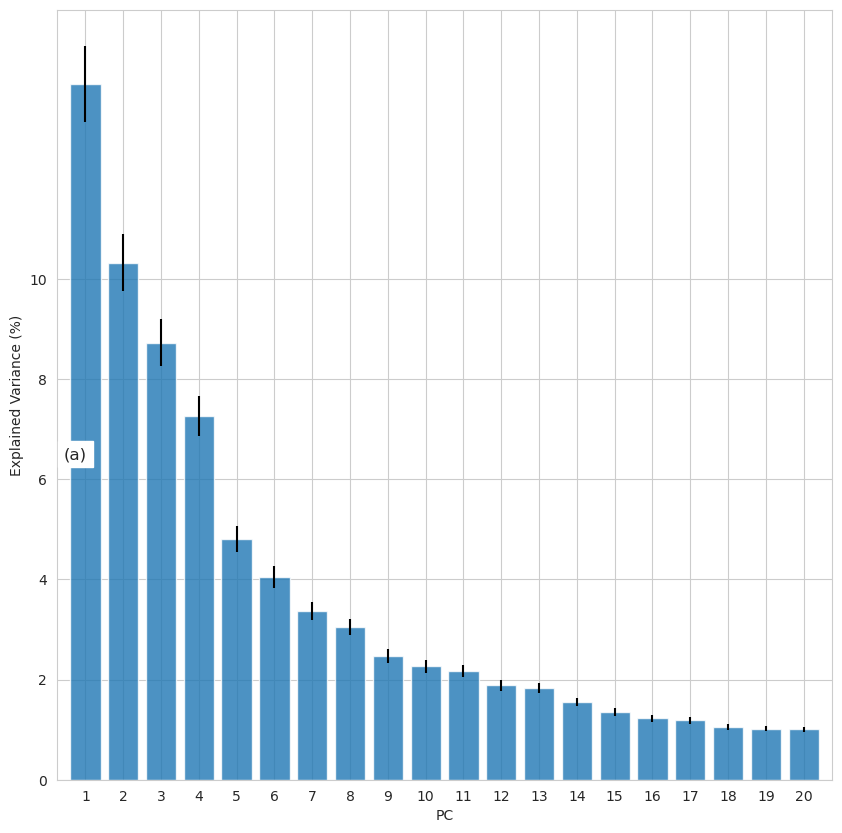

<Figure size 1000x1000 with 0 Axes>

In [14]:
# Create figure
fig = plt.figure(figsize=(10,10))
fname = '../figs/variance'
fmt = 'png'
nrows = 1
ncols = 1
nplots=nrows*ncols

sns.set_style("whitegrid")

# Variance Plots
ax = fig.add_subplot(nrows, ncols, 1)
# plot data
xvals = np.arange(neofs) + 1
ax.bar(xvals, pctvar[0:neofs], yerr=err[0:neofs], 
       color='tab:blue', alpha=0.8)

# x-axis
ax.set_xlabel('PC')
ax.set_xticks(xvals)
ax.set_xlim(1.-0.75, neofs+0.75)

# y-axis
ax.set_ylabel('Explained Variance (%)')
ax.set_yticks(np.arange(0, 12, 2))
# Subtitles
xpt = 5
ypt = 231
ax.annotate('(a)', (xpt, ypt), xycoords='axes points', fontsize=12.,
            backgroundcolor='white', zorder=100)

# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=fig.dpi)
fig.clf()

plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))

In [15]:
# choose neofs and npcs based on North Test - where separated
# to save, plot, etc.
neofs = max(n)
npcs = neofs

# Calculate EOFS (spatial modes)
eofs = calc_eofs(Xs, evecs, evals, neofs, mode=eofmode)

# Split eofs into separate arrays for each variable
npts = nlat*nlon
nvar = len(var_list)
# Reshape spatial dim back to 2D map
eofmodes = var_list
for i in np.arange(len(var_list)):
    tmp = eofs[:,i*npts:(i+1)*npts]
    eofmodes[i] = np.reshape(tmp, (neofs,nlat,nlon))
    
# Calculate PCs (time coefficients)
pcs = calc_pcs(Xs, evecs, evals, npcs, mode=eofmode)
# results in [ntim, npcs] to plot in PC plot

## loadings*
## in the case of t-mode these are our "pcs" or time-coefficients
## in the case of s-mode, these are our "eofs" or spatial loadings
loads = pcs

In [26]:
# Data for plotting 
lons = ds.lon.data
lats = ds.lat.data

udat = eofmodes[0][0:neofs,:,:]
vdat = eofmodes[1][0:neofs,:,:]
data = np.sqrt(udat**2 + vdat**2)

cflevs = np.arange(0, 100, 10)
cmap=cmo.deep
extend = 'max'
cb_lbl = 'IVT (kg m$^{-1}$ s$^{-1}$)'
    
print(np.nanmin(data), np.nanmax(data))

# Set up projection
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
dx = np.arange(ext[0],ext[1]+10,10)
dy = np.arange(ext[2],ext[3]+10,10)

# subtitles
eof_label = [ ]
pc_label = [ ]
var_label = [ ]
lbl = ['a', 'b', 'c', 'd', 'e', 'f']
for k in range(neofs):
    eof_label.append("({}) cEOF{:1d}".format(lbl[k], k+1,))
    pc_label.append("PC{:1d}".format(k+1,))
    var_label.append("{:.2f}%".format(pctvar[k]))
    
# hack for tick labels
share_bottom = [False, False, True]*2
share_right = [False]*3 + [True]*3

0.016067253630705797 38.345534399331406


In [19]:
# make a dict of the first n eofs with column labels for df
values = []
for i in range(neofs):
    values.append(loads[:,i])
    
keys = eof_label
dicts = dict(zip(keys, values))
# print(dicts)

# Create new dataframe
dates_arDays = ds.time.values
df_out = pd.DataFrame(dicts, index=dates_arDays)

# Save loadings
outfile = out_path + 'loadings_' + eofmode + dispmat + '.csv'
# np.savetxt(outfile, loads[:,0:neofs], fmt='%.4f', delimiter=',')
df_out.to_csv(outfile)

/home/dnash/miniconda3/envs/SEAK-impacts/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/scratch/dnash/job_34793666/ipykernel_223467/3496541171.py:9: MatplotlibDeprecationWarning: Passing an undefined label_mode is deprecated since 3.7 and will become an error two minor releases later. To silence this warning, pass "keep", which gives the same behaviour.
  axgr = AxesGrid(fig, 111, axes_class=axes_class,


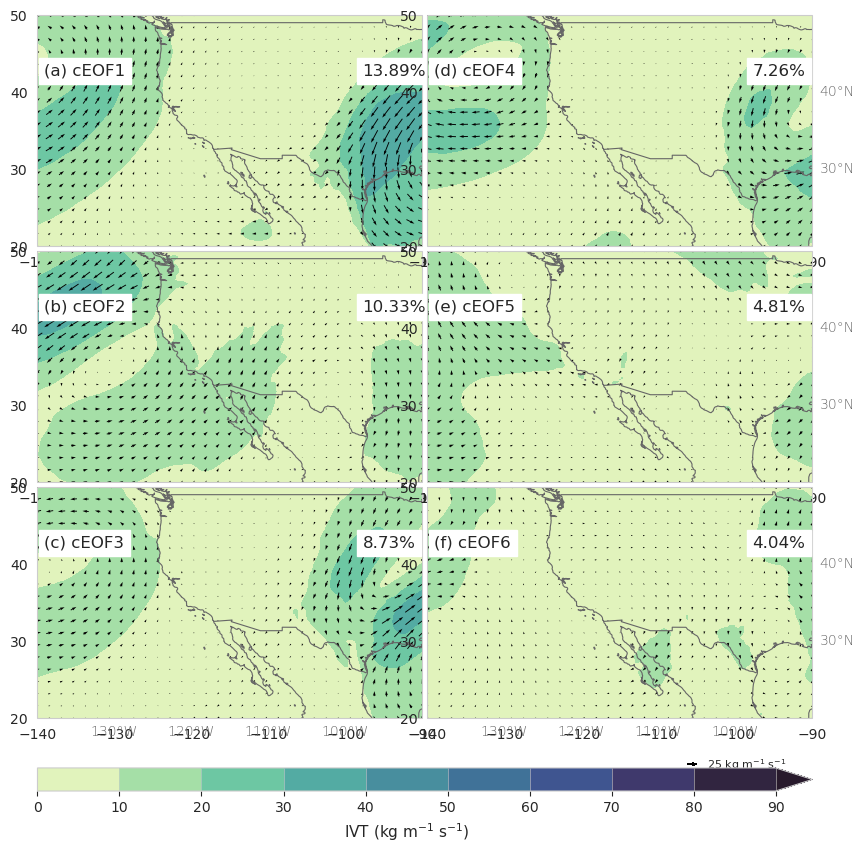

In [27]:
# Create figure
fig = plt.figure(figsize=(10,11))
filepath = '../figs/spatial_' + eofmode + dispmat + '.png'
nrows = 3
ncols = 2

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.05,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.45, cbar_size='5%',label_mode='',
                direction='column')

# Loop for drawing each plot
for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy,
                      left_lats=False, right_lats=share_right[k], bottom_lons=share_bottom[k])
    
    # Contour Filled
    cf = ax.contourf(lons, lats, data[k,:,:], transform=datacrs,
                     levels=cflevs, cmap=cmap, extend=extend)
    
    
    # Wind barbs / vectors
    # quiver key
    quiver_key= 25
    quiver_key_lbl= '25 kg m$^{-1}$ s$^{-1}$'
    quiver_scale= 20
    
    Q = ax.quiver(lons, lats, udat[k,:,:], vdat[k,:,:], transform=datacrs,
              color='black', pivot='middle', regrid_shape=20,
              angles='xy', scale_units='xy', scale=quiver_scale, units='xy')
    
    # subtitles
#     ax.set_title(eof_label[k], loc='left', fontsize=12)
    ax.annotate(eof_label[k], (5, 123), xycoords='axes points', fontsize=12.,
                backgroundcolor='white')
#     ax.set_title(var_label[k], loc='right', fontsize=12)
    ax.annotate(var_label[k], (234, 123), xycoords='axes points', fontsize=12.,
                backgroundcolor='white')
    
qk = ax.quiverkey(Q, 0.7, -0.2, quiver_key, quiver_key_lbl, labelpos='E',
                 coordinates='axes', fontproperties={'size': 8.0})
    
# single colorbar
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label(cb_lbl, fontsize=11)
cb.ax.tick_params(labelsize=10)
    
# Display figure
plt.savefig(filepath, dpi=300, bbox_inches='tight')
plt.show()

In [30]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# FUNCTIONS

def plot_optimal_k(data, neofs, kmax, create_plot=False, filename=None):
    """ Elbow plot to determine optimal number of clusters (k) 
    
    Parameters
    ----------
    data : array_like
        data to perform clustering on where rows= obs and cols = variables
    kmax : scalar, int
        maximum number of clusters; iteration over the interval k=[1,kmax]
    filename : string (optional)
        filename or path to save figure. Default is None (fig not saved).
    """
    
    # Cohesion = sum of sq dist of samples to their cluster center
    kclusters = np.arange(1, kmax, dtype=int) + 1
    cohesion = np.empty((neofs, kmax-1))
    silhouette = np.empty((neofs, kmax-1))
    upper = np.empty((neofs, kmax-1))
    lower = np.empty((neofs, kmax-1))
    
    # iterate over EOFs
    for i in range(neofs):
        X = data[:,0:i+2]
        
        # iterate over kclusters
        for j in range(len(kclusters)):
            ki = kclusters[j]
            km = KMeans(n_clusters=kclusters[j])
            cluster_labels = km.fit_predict(X)
            km = km.fit(X)
            cohesion[i, j] = (km.inertia_)

            # The silhouette_score gives the average value for all the samples.
            # This gives a perspective into the density and separation of the formed
            # clusters
            silhouette[i, j] = silhouette_score(X, cluster_labels)
            # Compute the silhouette scores for each sample
            sample_silhouette_values = silhouette_samples(X, cluster_labels)
            
            spread = []
            for m in range(ki):
                # Aggregate the silhouette scores for samples belonging to
                # cluster i, and sort them
                ith_cluster_silhouette_values = \
                    sample_silhouette_values[cluster_labels == m]

                ith_cluster_silhouette_values.sort()
                spread.append(ith_cluster_silhouette_values.max())
            
            lower[i, j] = min(spread)
            upper[i, j] = max(spread)

            
    if create_plot == True:
        fig = plt.figure()
        fig.set_size_inches((6.0,10.0))
        fig.dpi = 300
        sns.set_style("whitegrid")
        colors = ['tab:blue', 'tab:red', 'tab:green', 'k', 'orange', 'yellow']
        
        # Elbow plot
        ax = plt.subplot(2, 1, 1)
        for k in range(neofs):
            coh = cohesion[k, :]
            ax.plot(kclusters, coh, c=colors[k], marker='o', linewidth=2.0, markersize=7.0)
#             ax.set_title('Elbow Plot for Optimal K')
            ax.set_ylabel('Sum of Sq Dist (cohesion)')
            ax.set_xlabel('k (# of clusters)')
            ax.set_xlim(1., kmax+1)
#             ax.set_ylim(0, 210)
            ax.set_xticks(kclusters)
        
        # Silhouette plot
        ax2 = plt.subplot(2, 1, 2)
        for k in range(neofs):
            sil = silhouette[k, :]
            ax2.plot(kclusters, sil, c=colors[k], marker='o', linewidth=2.0, markersize=7.0)
            ax2.fill_between(kclusters, lower[k, :], upper[k, :], fc=colors[k], ec=None, alpha=0.2)
            ax2.set_ylabel('Mean Silhouette')
            ax2.set_xlabel('k (# of clusters)')
            ax2.set_xlim(1., kmax+1)
            ax2.set_ylim(0, 1.)
            ax2.set_xticks(kclusters)
        
        if filename:
            # Save the figure
            fig.savefig(filename, bbox_inches='tight', dpi=fig.dpi)
            fig.clf()
    else:
        return kclusters, cohesion

/home/dnash/miniconda3/envs/SEAK-impacts/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/dnash/miniconda3/envs/SEAK-impacts/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/dnash/miniconda3/envs/SEAK-impacts/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/dnash/miniconda3/envs/SEAK-impacts/lib/python3.12/site-packages/sklearn/cluster/_kmeans.

../figs/elbow_tcor.png


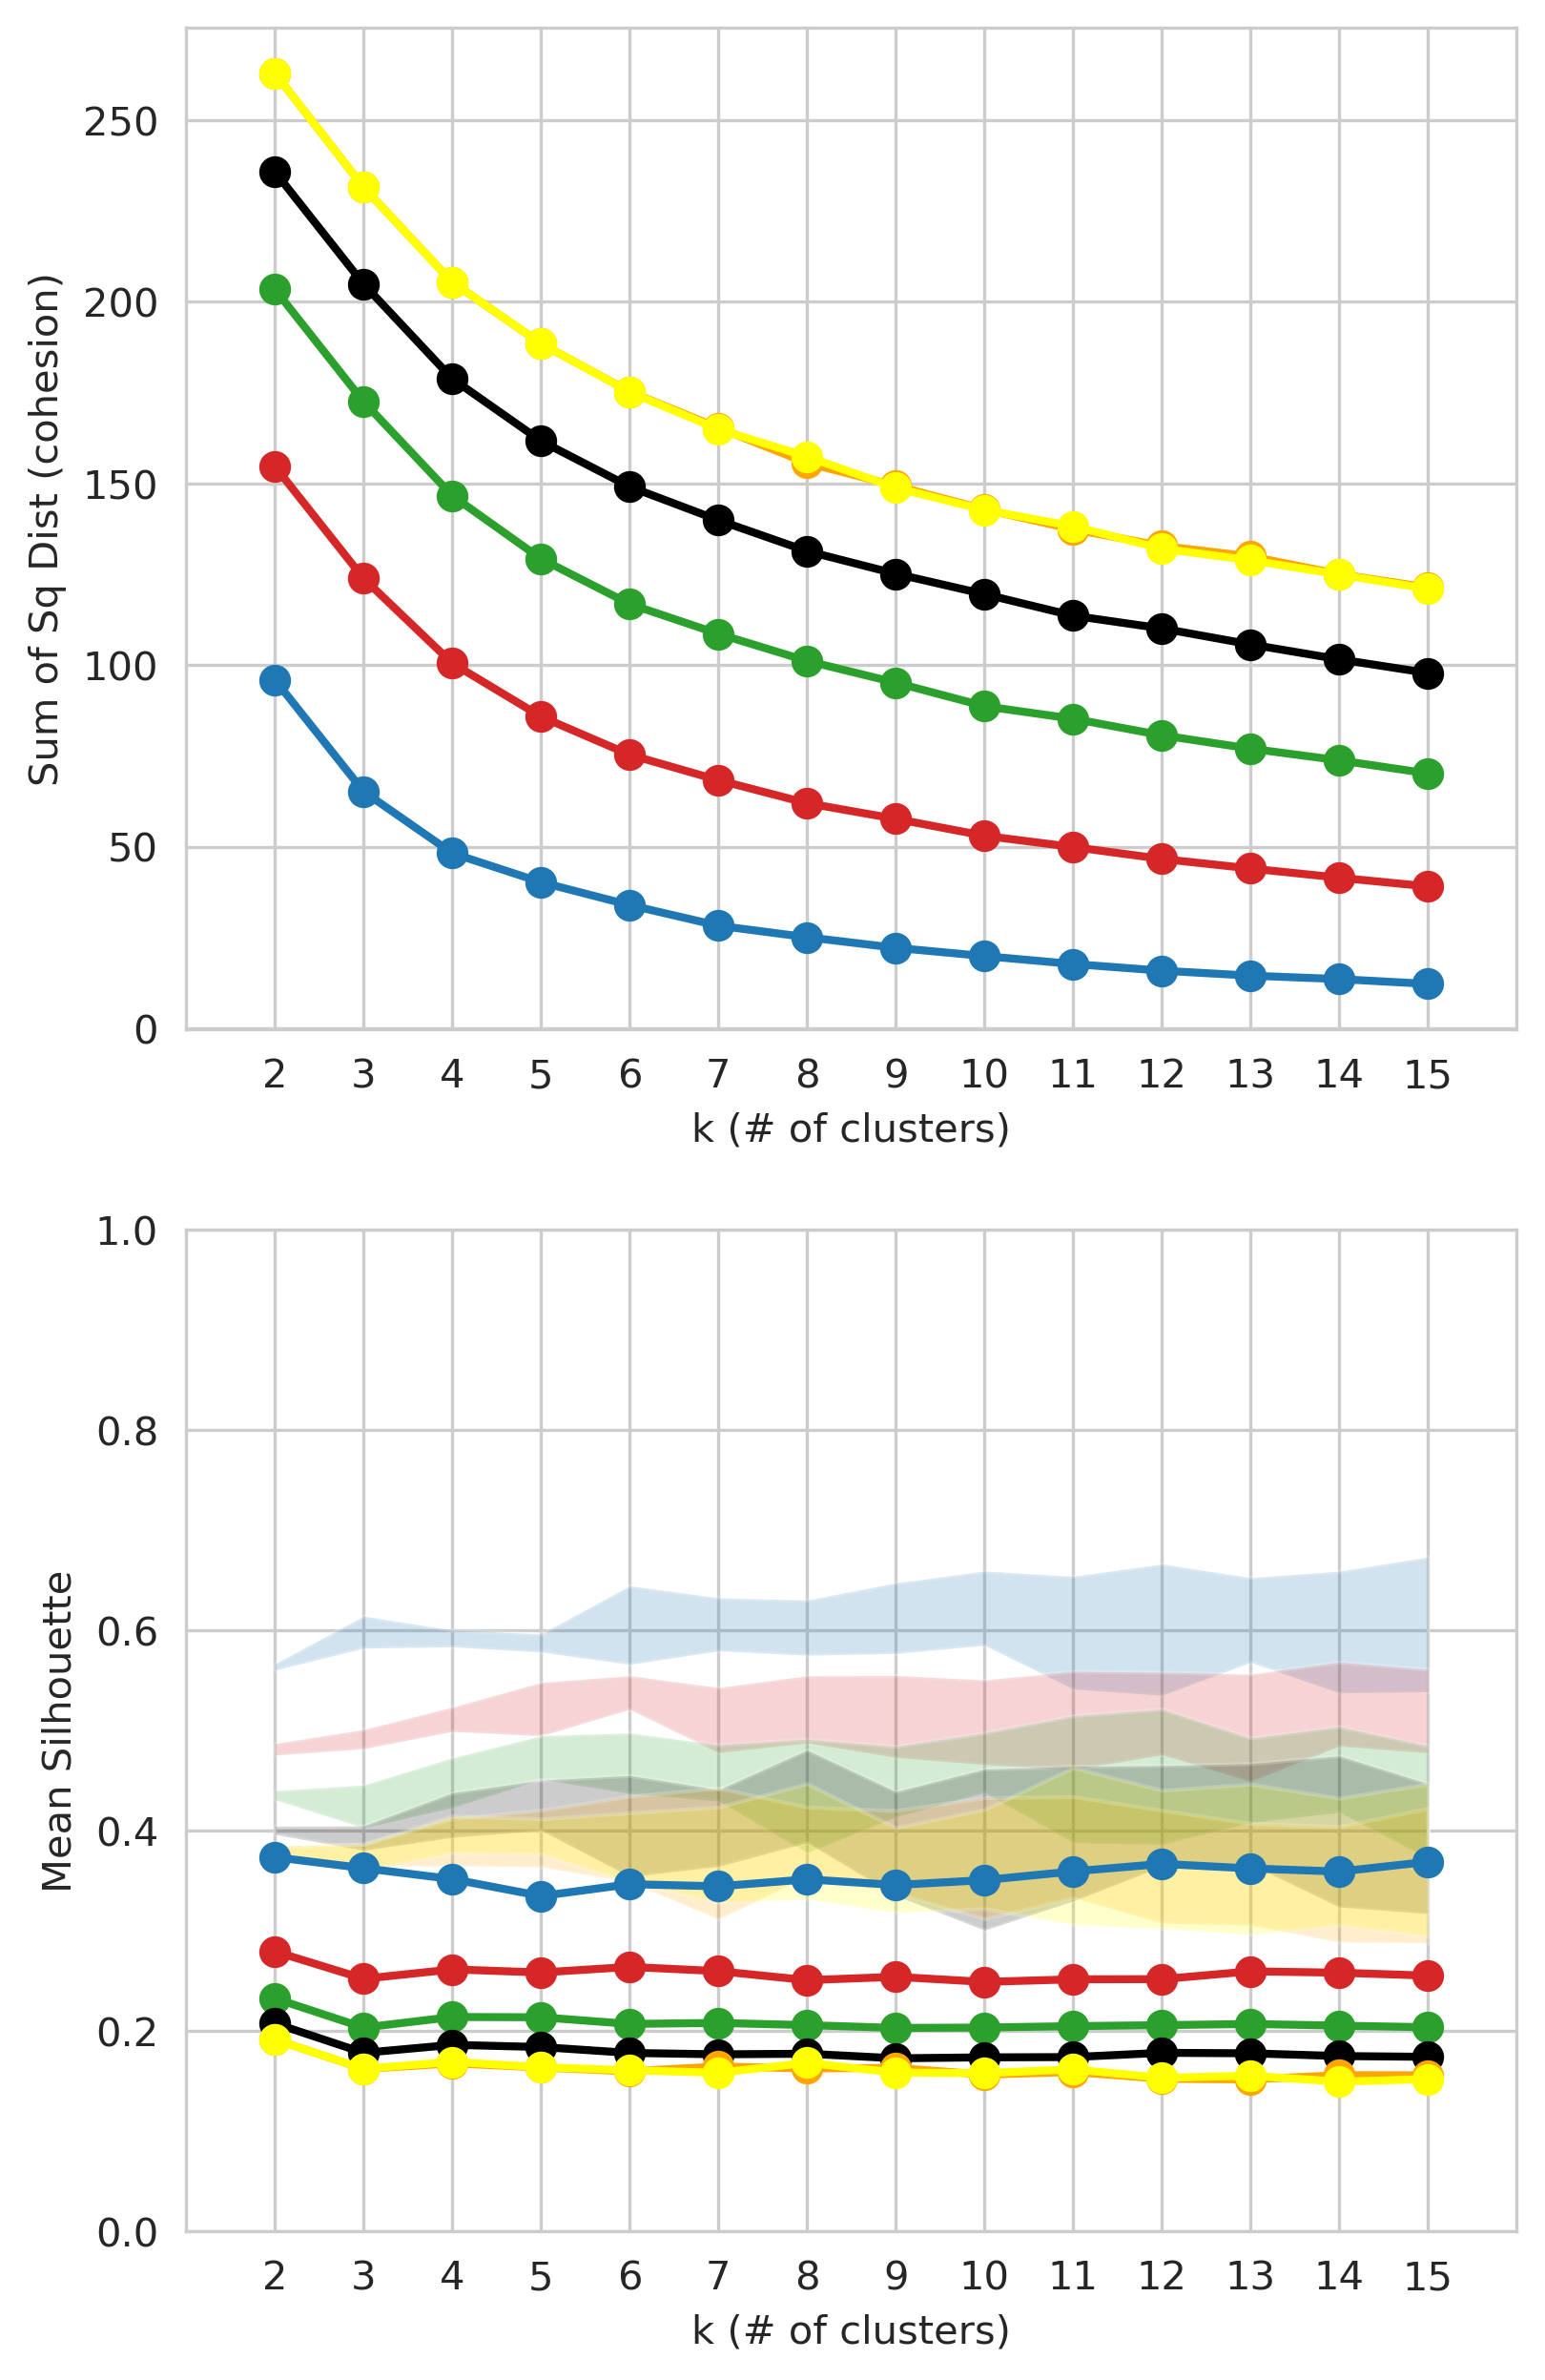

<Figure size 1800x3000 with 0 Axes>

In [31]:
# Determine optimal K
# maximum number of clusters (number of iterations)
kmax = 15

# Elbow plot
outfile = '../figs/elbow_' + eofmode + dispmat + '.png'
plot_optimal_k(loads, neofs, kmax, create_plot=True, filename=outfile)

print(outfile)
display(Image(outfile))

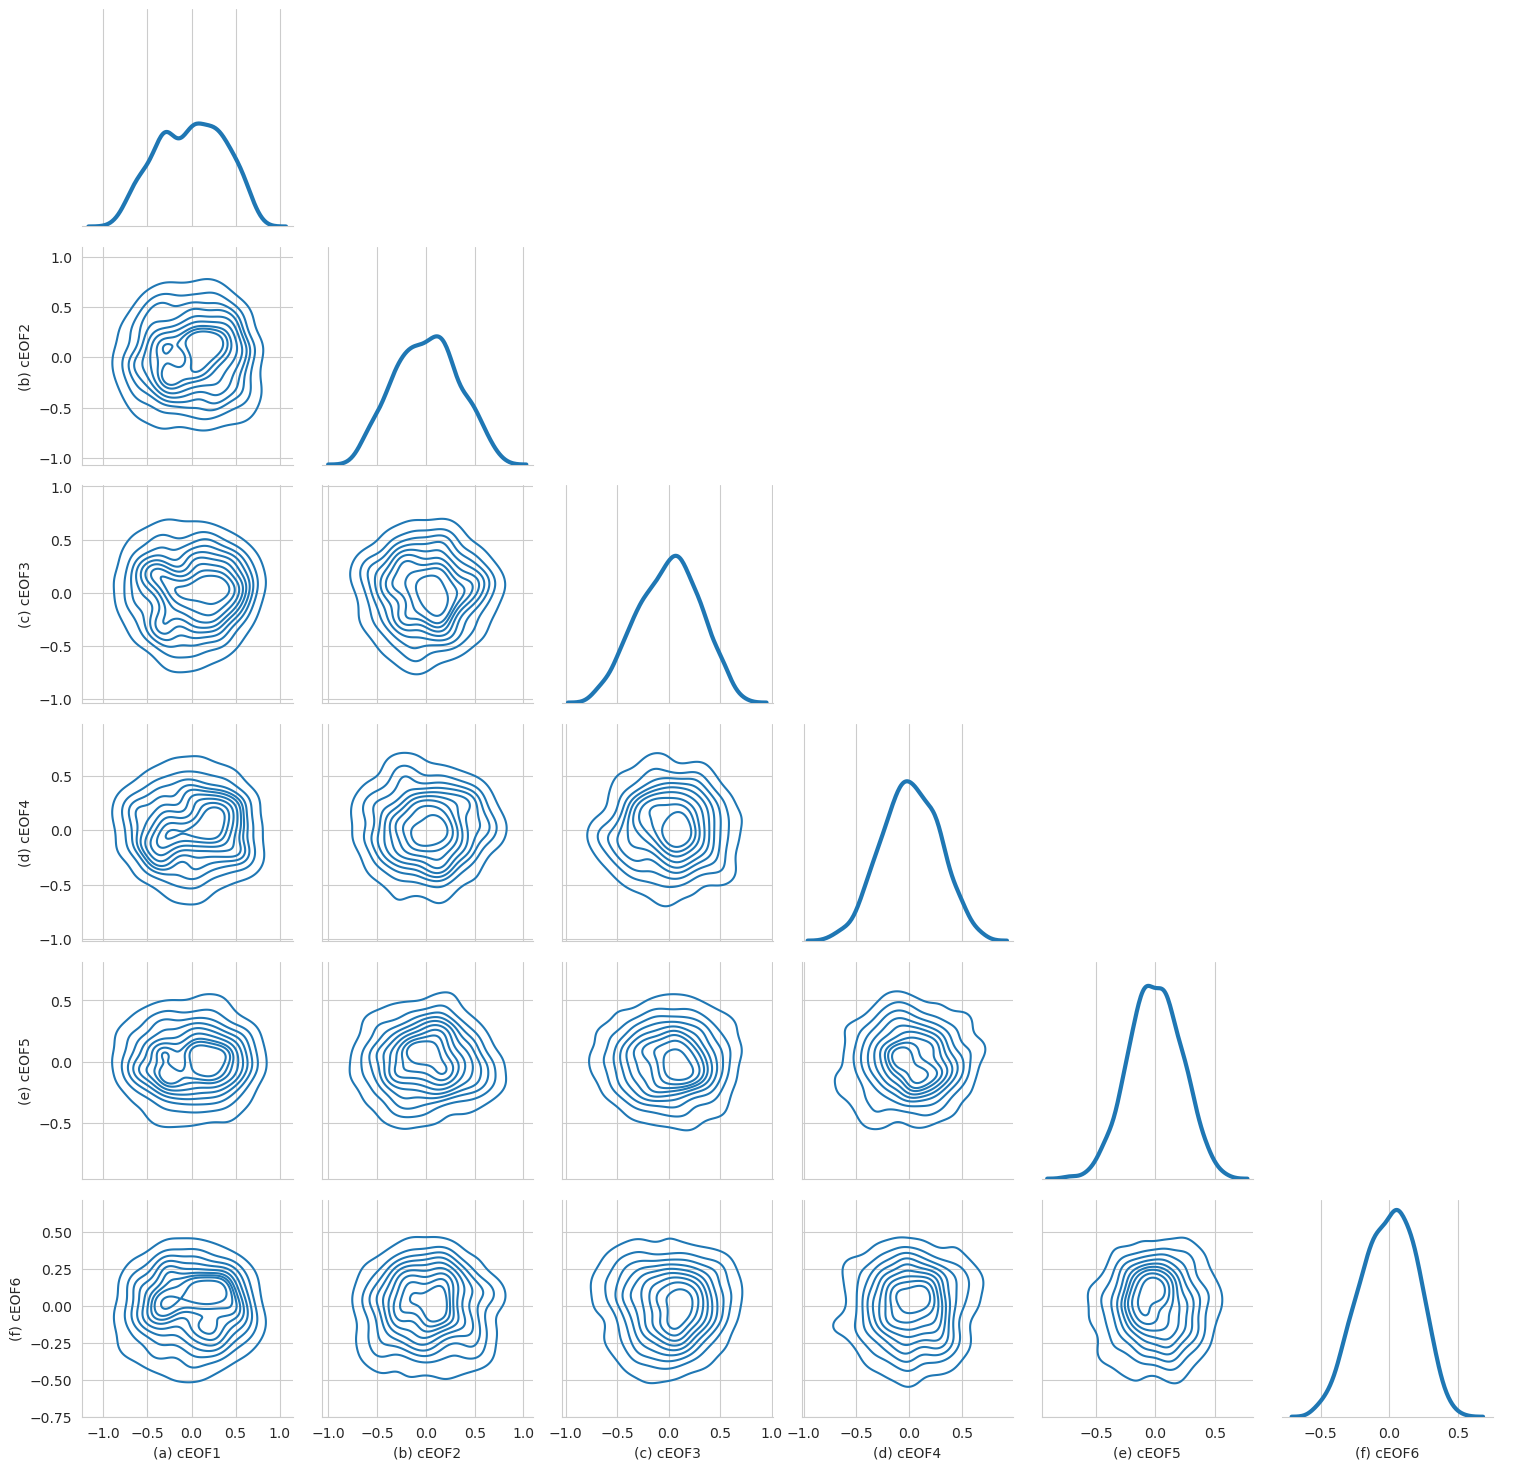

In [32]:
# determine optimal k by examining the kde of the eofs
g = sns.PairGrid(df_out, diag_sharey=True, corner=True)
# g.map_upper(sns.kdeplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw = 3)
g = g.add_legend(fontsize=14)

outfile = '../figs/hist_kde_' + eofmode + dispmat + '.png'
g.savefig(outfile)